In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
table1=pd.read_excel('HeatExchangerNetwork.xlsx')
table1.set_index("Stream Number",inplace=True)
table1["Stream Type"]=np.where(table1["Ts"]>table1["Tt"],"HOT","COLD") #generalized to get stream type for any question
table1["FCp"]=np.where(table1["Stream Type"]=="HOT",table1["FCp"]-(2*table1["FCp"]),table1["FCp"]) #FCp values for all hot streams become negative. This convention will be used later in calculations
table1

,FCp,Ts,Tt,Stream Type
Stream Number,,,,
1,-2.376,590,400,HOT
2,-1.577,471,200,HOT
3,-1.320,533,150,HOT
4,1.600,200,400,COLD
5,1.600,100,430,COLD
6,4.128,300,400,COLD
7,2.624,150,280,COLD


In [3]:
Tmin=input("Enter your Tmin in degree Celsius:") #Put this in excel- this can be used as an input later when we know the optimum deltaTmin
Tmin=int(Tmin)

Enter your Tmin in degree Celsius:50


In [4]:
hot_streams=table1[table1["Stream Type"]=="HOT"]#get a separate dataframe for only hot streams
cold_streams=table1[table1["Stream Type"]=="COLD"]#get a separate dataframe for only cold streams
hot_streams

,FCp,Ts,Tt,Stream Type
Stream Number,,,,
1,-2.376,590,400,HOT
2,-1.577,471,200,HOT
3,-1.320,533,150,HOT


In [5]:
#Generalized
temp_left=cold_streams["Ts"].append(cold_streams["Tt"]).append(hot_streams["Ts"]-Tmin).append(hot_streams["Tt"]-Tmin).sort_values(ascending=False) #this will get all the requisite temperature values for the left side (cold streams) of problem table algorithm 
temp_left=list(dict.fromkeys(temp_left)) #this will drop duplicates, which in our case was 40
temp_right=hot_streams["Ts"].append(hot_streams["Tt"]).append(cold_streams["Ts"]+Tmin).append(cold_streams["Tt"]+Tmin).sort_values(ascending=False) #this will get all the requisite temperature values for the right side (hot streams) of problem table algorithm
temp_right=list(dict.fromkeys(temp_right)) #this will drop duplicates, which in our case was 60

In [6]:
problem_table=pd.DataFrame()
problem_table["Network"]=[i for i in range(len(temp_right))]
problem_table["Network"]=problem_table["Network"].astype(str)
problem_table["Sub"]=np.repeat("SN",len(temp_right))
problem_table['Subnetwork'] = problem_table['Sub']+problem_table["Network"]
problem_table=problem_table.drop(["Sub","Network"],axis=1)
problem_table["Tleft"]=temp_left
problem_table["Tright"]=temp_right

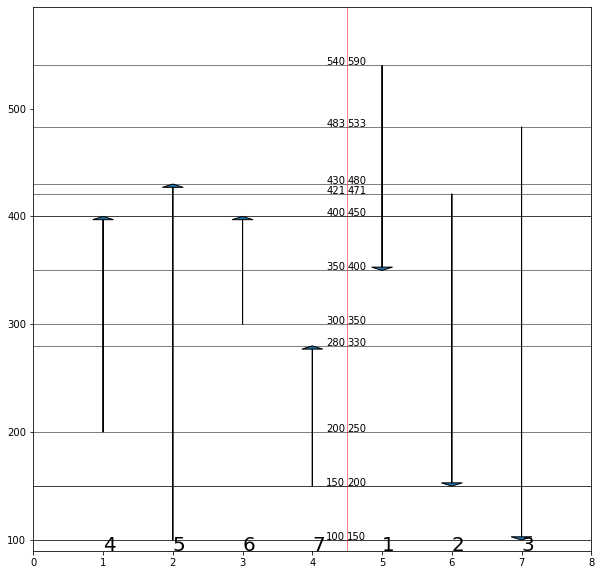

In [7]:
plt.figure(figsize=(10,10))
plt.xlim(0,len(table1.index)+1)
plt.ylim(0.9*problem_table["Tleft"].min(),1.1*problem_table["Tleft"].max())
for stream_number,Ts,Tt,stream_name in zip(range(len(cold_streams)),cold_streams["Ts"],cold_streams["Tt"],cold_streams.index):
    plt.arrow(stream_number+1,Ts,0,Tt-Ts,length_includes_head=True,head_length=3.0,head_width=0.3)
    plt.axhline(Ts,color='black',lw=0.5)
    plt.axhline(Tt,color='black',lw=0.5)
    plt.text(stream_number+1,0.9*problem_table["Tleft"].min(),stream_name,fontsize=20)
for stream_number,Ts,Tt,stream_name in zip(range(len(cold_streams),len(cold_streams)+len(hot_streams)),hot_streams["Ts"],hot_streams["Tt"],hot_streams.index):
    plt.arrow(stream_number+1,Ts-Tmin,0,Tt-Ts,length_includes_head=True,head_length=3.0,head_width=0.3)
    plt.axhline(Ts-Tmin,color='black',lw=0.5)
    plt.axhline(Tt-Tmin,color='black',lw=0.5)
    plt.text(stream_number+1,0.9*problem_table["Tleft"].min(),stream_name,fontsize=20)
plt.axvline(len(cold_streams)+0.5,color='red',lw=0.5)
for j in problem_table["Tleft"]:
    plt.text(len(cold_streams)+0.2,j,j)
    plt.text(len(cold_streams)+0.5,j,j+Tmin)
plt.show()

In [8]:
streams_involved=np.zeros((len(problem_table),len(table1)+1),dtype='int')
cold_streams_involved_1=np.zeros((len(problem_table),len(table1)+1),dtype='int')
hot_streams_involved_1=np.zeros((len(problem_table),len(table1)+1),dtype='int')
for i in range(len(problem_table)):
    for j in range(len(cold_streams)):
        cold_streams_involved=np.where(cold_streams.iloc[j]["Ts"]<=problem_table.iloc[i]["Tleft"]<cold_streams.iloc[j]["Tt"],cold_streams.iloc[j].name,0)
        streams_involved[i][cold_streams_involved]=cold_streams_involved
        cold_streams_involved_1[i][cold_streams_involved]=cold_streams_involved
    for k in range(len(hot_streams)):
        hot_streams_involved=np.where(hot_streams.iloc[k]["Tt"]<=problem_table.iloc[i]["Tright"]<hot_streams.iloc[k]["Ts"],hot_streams.iloc[k].name,0)
        streams_involved[i][hot_streams_involved]=hot_streams_involved
        hot_streams_involved_1[i][hot_streams_involved]=hot_streams_involved

In [9]:
problem_table

,Subnetwork,Tleft,Tright
0,SN0,540,590
1,SN1,483,533
2,SN2,430,480
3,SN3,421,471
4,SN4,400,450
5,SN5,350,400
6,SN6,300,350
7,SN7,280,330
8,SN8,200,250
9,SN9,150,200


In [10]:
hot_streams

,FCp,Ts,Tt,Stream Type
Stream Number,,,,
1,-2.376,590,400,HOT
2,-1.577,471,200,HOT
3,-1.320,533,150,HOT


In [11]:
problem_table["Streams Involved"]=[streams_involved[i] for i in range(len(problem_table))] #This is generalized

In [12]:
difference=[0]
for i in range(1,len(problem_table)):
    difference.append(problem_table["Tleft"][i-1]-problem_table["Tleft"][i])
problem_table["Temperature Difference"]=difference

In [13]:
k=np.zeros(len(problem_table))
for i in range(len(problem_table)):
    streams=np.extract(problem_table["Streams Involved"][i]!=0, problem_table["Streams Involved"][i]) #the 2 should range till length of problem table
    sum=0
    n=len(streams)
    for n in range(len(streams)):
        sum=sum+table1.loc[streams[n]]["FCp"] #the summation should be carried upto length of streams
    k[i]=sum

In [14]:
problem_table["Summation of FCp"]=k#This is generalized
problem_table["Deficit"]=problem_table["Summation of FCp"]*problem_table["Temperature Difference"]#This is generalized
x=[-problem_table["Deficit"].cumsum()[i-1] for i in range(1,len(problem_table))]
x=np.array(x)
y=[0]
y=np.array(y)
z=np.concatenate((y,x))
problem_table["Accumulated Input"]=z #This is generalized
problem_table["Accumulated Output"]=-problem_table["Deficit"].cumsum() #This is generalized
problem_table["Heat Flows Input"]=abs(problem_table["Accumulated Output"].min())+problem_table["Accumulated Input"] #This is generalized
problem_table["Heat Flows Output"]=abs(problem_table["Accumulated Output"].min())+problem_table["Accumulated Output"] #This is generalized

In [15]:
problem_table

,Subnetwork,Tleft,Tright,Streams Involved,Temperature Difference,Summation of FCp,Deficit,Accumulated Input,Accumulated Output,Heat Flows Input,Heat Flows Output
0,SN0,540,590,"[0, 0, 0, 0, 0, 0, 0, 0]",0,0.000,0.000,0.000,-0.000,217.553,217.553
1,SN1,483,533,"[0, 1, 0, 0, 0, 0, 0, 0]",57,-2.376,-135.432,-0.000,135.432,217.553,352.985
2,SN2,430,480,"[0, 1, 0, 3, 0, 0, 0, 0]",53,-3.696,-195.888,135.432,331.320,352.985,548.873
3,SN3,421,471,"[0, 1, 0, 3, 0, 5, 0, 0]",9,-2.096,-18.864,331.320,350.184,548.873,567.737
4,SN4,400,450,"[0, 1, 2, 3, 0, 5, 0, 0]",21,-3.673,-77.133,350.184,427.317,567.737,644.870
5,SN5,350,400,"[0, 1, 2, 3, 4, 5, 6, 0]",50,2.055,102.750,427.317,324.567,644.870,542.120
6,SN6,300,350,"[0, 0, 2, 3, 4, 5, 6, 0]",50,4.431,221.550,324.567,103.017,542.120,320.570
7,SN7,280,330,"[0, 0, 2, 3, 4, 5, 0, 0]",20,0.303,6.060,103.017,96.957,320.570,314.510
8,SN8,200,250,"[0, 0, 2, 3, 4, 5, 0, 7]",80,2.927,234.160,96.957,-137.203,314.510,80.350
9,SN9,150,200,"[0, 0, 2, 3, 0, 5, 0, 7]",50,1.327,66.350,-137.203,-203.553,80.350,14.000


In [16]:
hot_composite_curve=pd.DataFrame()
hot_composite_curve["Temperature"]=problem_table["Tright"].values[::-1]
hot_composite_curve["Streams Involved"]=[hot_streams_involved_1[len(hot_streams_involved_1)-i-1] for i in range(len(hot_streams_involved_1))]
k=np.zeros(len(problem_table))
for i in range(len(problem_table)):
    streams=np.extract(hot_composite_curve["Streams Involved"][i]!=0, hot_composite_curve["Streams Involved"][i]) #the 2 should range till length of problem table
    sum=0
    n=len(streams)
    for n in range(len(streams)):
        sum=sum+table1.loc[streams[n]]["FCp"] #the summation should be carried upto length of streams
    k[i]=sum
hot_composite_curve["Summation of FCp"]=k#This is generalized
hot_composite_curve["Difference"]=problem_table["Temperature Difference"].values[::-1]
hot_composite_curve["Enthalpy not Final"]=hot_composite_curve["Difference"]*hot_composite_curve["Summation of FCp"]
hot_composite_curve["Enthalpy not Final Cumulative"]=hot_composite_curve["Enthalpy not Final"].cumsum()
final_enthalpy_hot_streams=np.concatenate((0, abs(hot_composite_curve["Enthalpy not Final Cumulative"]).values[:-1]), axis=None)

In [17]:
cold_composite_curve=pd.DataFrame()
cold_composite_curve["Temperature"]=problem_table["Tleft"].values[::-1]
cold_composite_curve["Streams Involved"]=[cold_streams_involved_1[len(cold_streams_involved_1)-i-1] for i in range(len(cold_streams_involved_1))]
k=np.zeros(len(problem_table))
for i in range(len(problem_table)):
    streams=np.extract(cold_composite_curve["Streams Involved"][i]!=0, cold_composite_curve["Streams Involved"][i]) #the 2 should range till length of problem table
    sum=0
    n=len(streams)
    for n in range(len(streams)):
        sum=sum+table1.loc[streams[n]]["FCp"] #the summation should be carried upto length of streams
    k[i]=sum
cold_composite_curve["Summation of FCp"]=k#This is generalized
cold_composite_curve["Difference"]=problem_table["Temperature Difference"].values[::-1]
cold_composite_curve["Enthalpy not Final"]=cold_composite_curve["Difference"]*cold_composite_curve["Summation of FCp"]
cold_composite_curve["Enthalpy not Final Cumulative"]=cold_composite_curve["Enthalpy not Final"].cumsum()
final_enthalpy_cold_streams=np.concatenate((0, abs(cold_composite_curve["Enthalpy not Final Cumulative"]).values[:-1]), axis=None)

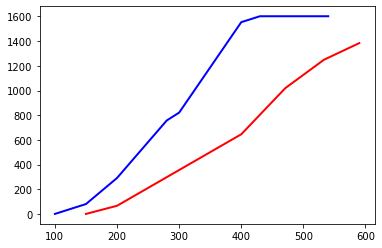

In [18]:
#Combined Composite Curve
plt.plot(hot_composite_curve["Temperature"],final_enthalpy_hot_streams,lw=2,color='red')
plt.plot(cold_composite_curve["Temperature"],final_enthalpy_cold_streams,lw=2,color='blue')
plt.show()

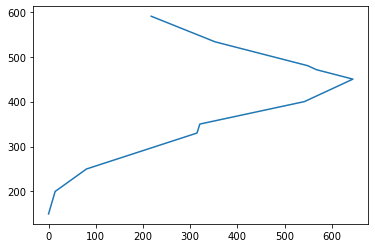

In [19]:
#Grand Composite Curve
plt.plot(problem_table["Heat Flows Output"],problem_table["Tright"])
plt.show()

In [20]:
#problem_table=problem_table.drop([0]) #Dropping the SN0. It was only done to ease our calculations
problem_table

,Subnetwork,Tleft,Tright,Streams Involved,Temperature Difference,Summation of FCp,Deficit,Accumulated Input,Accumulated Output,Heat Flows Input,Heat Flows Output
0,SN0,540,590,"[0, 0, 0, 0, 0, 0, 0, 0]",0,0.000,0.000,0.000,-0.000,217.553,217.553
1,SN1,483,533,"[0, 1, 0, 0, 0, 0, 0, 0]",57,-2.376,-135.432,-0.000,135.432,217.553,352.985
2,SN2,430,480,"[0, 1, 0, 3, 0, 0, 0, 0]",53,-3.696,-195.888,135.432,331.320,352.985,548.873
3,SN3,421,471,"[0, 1, 0, 3, 0, 5, 0, 0]",9,-2.096,-18.864,331.320,350.184,548.873,567.737
4,SN4,400,450,"[0, 1, 2, 3, 0, 5, 0, 0]",21,-3.673,-77.133,350.184,427.317,567.737,644.870
5,SN5,350,400,"[0, 1, 2, 3, 4, 5, 6, 0]",50,2.055,102.750,427.317,324.567,644.870,542.120
6,SN6,300,350,"[0, 0, 2, 3, 4, 5, 6, 0]",50,4.431,221.550,324.567,103.017,542.120,320.570
7,SN7,280,330,"[0, 0, 2, 3, 4, 5, 0, 0]",20,0.303,6.060,103.017,96.957,320.570,314.510
8,SN8,200,250,"[0, 0, 2, 3, 4, 5, 0, 7]",80,2.927,234.160,96.957,-137.203,314.510,80.350
9,SN9,150,200,"[0, 0, 2, 3, 0, 5, 0, 7]",50,1.327,66.350,-137.203,-203.553,80.350,14.000


In [21]:
pinch_temp=problem_table[problem_table["Heat Flows Output"]==0.0]["Tright"]
pinch_temp=pinch_temp.values
pinch_temp=pinch_temp[0]#This is the pinch temperature:generalized
minimum_hot_utility=problem_table.iloc[0]["Heat Flows Input"] #This is minimum hot utility: generalized
minimum_cold_utility=problem_table.iloc[-1]["Heat Flows Output"] #This is minimum cold utility: generalized
pinch_temp,minimum_hot_utility,minimum_cold_utility

(150, 217.5530000000001, 0.0)

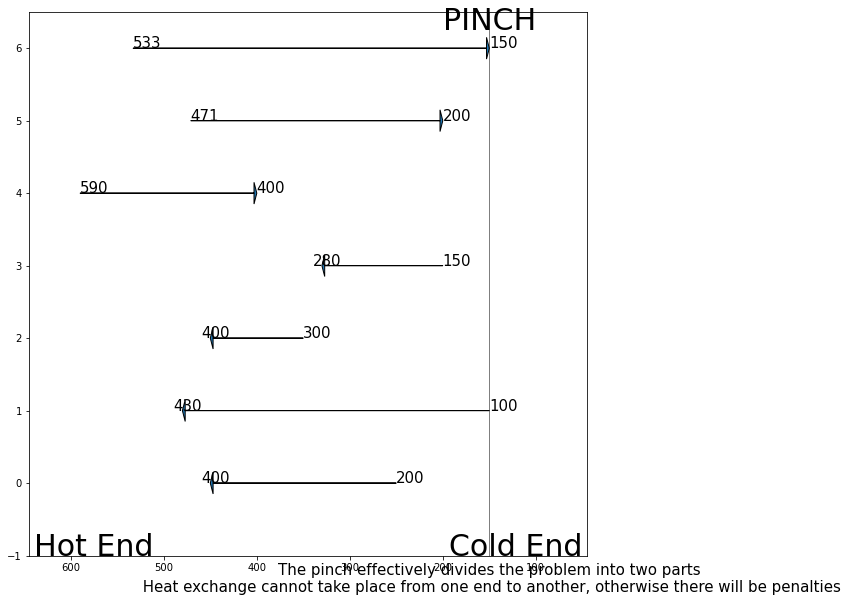

In [22]:
plt.figure(figsize=(10,10)) #The figure size is specific. It needs to be adjusted accordingly by the user.
plt.ylim(-1,len(table1)-0.5)
plt.xlim(max(table1["Ts"].max(),table1["Tt"].max())+Tmin+5,min(table1["Ts"].min(),table1["Tt"].min())-Tmin-5) #this will also invert the x-axis limits
plt.axvline(pinch_temp,color='black',lw=0.5)
plt.text(pinch_temp,len(table1)-0.75,"PINCH",ha='center',fontsize=30)
for i in range(len(cold_streams)):
    plt.arrow(cold_streams.iloc[i]["Ts"]+Tmin,i,cold_streams.iloc[i]["Tt"]-cold_streams.iloc[i]["Ts"],0,length_includes_head=True,head_length=3.0,head_width=0.3)
    plt.text(cold_streams.iloc[i]["Ts"]+Tmin,i,cold_streams.iloc[i]["Ts"],fontsize=15)
    plt.text(cold_streams.iloc[i]["Tt"]+Tmin+10,i,cold_streams.iloc[i]["Tt"],fontsize=15)
for i in range(len(cold_streams),len(cold_streams)+len(hot_streams)):
    plt.arrow(hot_streams.iloc[i-len(cold_streams)]["Ts"],i,hot_streams.iloc[i-len(cold_streams)]["Tt"]-hot_streams.iloc[i-len(cold_streams)]["Ts"],0,length_includes_head=True,head_length=3.0,head_width=0.3)
    plt.text(hot_streams.iloc[i-len(cold_streams)]["Ts"],i,hot_streams.iloc[i-len(cold_streams)]["Ts"],fontsize=15)
    plt.text(hot_streams.iloc[i-len(cold_streams)]["Tt"],i,hot_streams.iloc[i-len(cold_streams)]["Tt"],fontsize=15)
plt.text(max(table1["Ts"].max(),table1["Tt"].max())+Tmin,-1,"Hot End",fontsize=30)
plt.text(min(table1["Ts"].min(),table1["Tt"].min())-Tmin,-1,"Cold End",fontsize=30,ha="right")
plt.text(pinch_temp,-1.5,"The pinch effectively divides the problem into two parts\n Heat exchange cannot take place from one end to another, otherwise there will be penalties",ha="center",fontsize=15) 
plt.show()

In [23]:
problem_table

,Subnetwork,Tleft,Tright,Streams Involved,Temperature Difference,Summation of FCp,Deficit,Accumulated Input,Accumulated Output,Heat Flows Input,Heat Flows Output
0,SN0,540,590,"[0, 0, 0, 0, 0, 0, 0, 0]",0,0.000,0.000,0.000,-0.000,217.553,217.553
1,SN1,483,533,"[0, 1, 0, 0, 0, 0, 0, 0]",57,-2.376,-135.432,-0.000,135.432,217.553,352.985
2,SN2,430,480,"[0, 1, 0, 3, 0, 0, 0, 0]",53,-3.696,-195.888,135.432,331.320,352.985,548.873
3,SN3,421,471,"[0, 1, 0, 3, 0, 5, 0, 0]",9,-2.096,-18.864,331.320,350.184,548.873,567.737
4,SN4,400,450,"[0, 1, 2, 3, 0, 5, 0, 0]",21,-3.673,-77.133,350.184,427.317,567.737,644.870
5,SN5,350,400,"[0, 1, 2, 3, 4, 5, 6, 0]",50,2.055,102.750,427.317,324.567,644.870,542.120
6,SN6,300,350,"[0, 0, 2, 3, 4, 5, 6, 0]",50,4.431,221.550,324.567,103.017,542.120,320.570
7,SN7,280,330,"[0, 0, 2, 3, 4, 5, 0, 0]",20,0.303,6.060,103.017,96.957,320.570,314.510
8,SN8,200,250,"[0, 0, 2, 3, 4, 5, 0, 7]",80,2.927,234.160,96.957,-137.203,314.510,80.350
9,SN9,150,200,"[0, 0, 2, 3, 0, 5, 0, 7]",50,1.327,66.350,-137.203,-203.553,80.350,14.000


In [25]:
problem_table.to_excel("finalanswer.xlsx")  